In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.formula.api as smf
import numpy as np
from scipy.special import logit, expit
from datetime import date
%matplotlib inline

Consumer sentiment data from https://data.sca.isr.umich.edu/

In [2]:
sentiment = pd.read_csv('consumer_sentiment.csv')

Let's take a look at the consumer sentiment data

In [3]:
sentiment

,CASEID,YYYYMM,YYYYQ,YYYY,ID,IDPREV,DATEPR,ICS,ICC,ICE
0,1,197801,19781,1978,1,,,76.71,116.23,51.32
1,2,197801,19781,1978,2,,,121.12,154.08,99.94
2,3,197801,19781,1978,3,,,2.70,2.70,2.70
3,4,197801,19781,1978,4,,,76.71,154.08,27.01
4,5,197801,19781,1978,5,,,121.12,116.23,124.25
...,...,...,...,...,...,...,...,...,...,...
312726,312727,202307,20233,2023,2097,1130,202301,31.60,39.84,26.31
312727,312728,202307,20233,2023,2098,1038,202301,76.01,153.38,26.31
312728,312729,202307,20233,2023,2099,1141,202301,61.21,115.53,26.31
312729,312730,202307,20233,2023,2100,1071,202301,90.81,77.69,99.24


Group by month and get the mean ICC, ICS, and ICE measurements.

In [4]:
sentiment['DATE'] = pd.to_datetime(sentiment.YYYYMM, format="%Y%m")

data = sentiment.groupby(['DATE'])[['ICC','ICS','ICE']].mean()

 These are indexes computed from the proportion of positive to negative replies to five questions

The ICC concerns the response to:
> "We are interested in how people are getting along financially these days. Would  you say that you (and your family living there) are better off or worse off financially than you were a year ago?"

> "About the big things people buy for their homes--such as furniture, a refrigerator, stove, television, and things like that. Generally speaking, do you think now is a good or bad time for people to buy major household items?"

The ICE concerns the responses to:
> "Now looking ahead--do you think that a year from now you (and your family living there) will be better off financially, or worse off, or just about the same as now?"

> "Now turning to business conditions in the country as a whole--do you think that during the next twelve months we'll have good times financially, or bad times, or what?"

> "Looking ahead, which would you say is more likely--that in the country as a whole we'll have continuous good times during the next five years or so, or that we will have periods of widespread unemployment or depression, or what?"

And the ICS concerns all five.

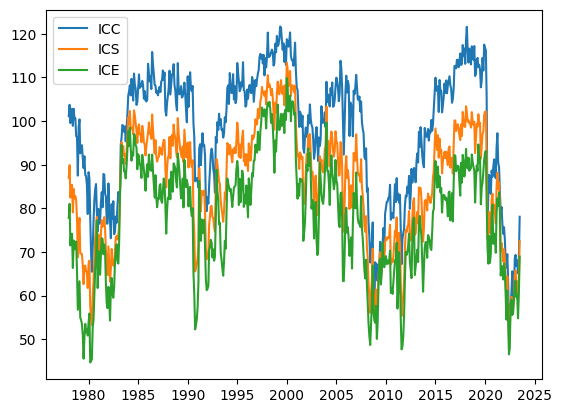

In [5]:
plt.plot(data.ICC)
plt.plot(data.ICS)
plt.plot(data.ICE)
plt.legend(["ICC", "ICS", "ICE"])
plt.show()

In [6]:
data.describe()

,ICC,ICS,ICE
count,547.000000,547.000000,547.000000
mean,97.895492,85.993063,78.345096
std,14.598126,13.455466,13.566450
min,53.548571,49.282608,44.683748
25%,87.424618,75.245689,68.378410
50%,101.969485,89.598520,80.764400
75%,108.471766,95.848786,88.520986
max,121.664360,113.337352,109.857609


In [7]:
data.corr()

,ICC,ICS,ICE
ICC,1.000000,0.946378,0.850341
ICS,0.946378,1.000000,0.974749
ICE,0.850341,0.974749,1.000000


The three indexes are closely correlated. The ICE tends to be lower, the ICC tends to be higher, and the ICS is a combination of the two. The ICC is asking about current economic conditions while the ICS is asking about what people's expectations are, so it seems that even when people think things are going well, they are often concerned about the future.

How well do these correlate with presidential elections?

In [8]:
election_results = pd.DataFrame([{'month': date(2020, 11, 1), 'incumbent': 46.8, 'challenger': 51.3},
                                 {'month': date(2016, 11, 1), 'incumbent': 48.2, 'challenger': 46.1},
                                 {'month': date(2012, 11, 1), 'incumbent': 51.1, 'challenger': 47.2},
                                 {'month': date(2008, 11, 1), 'incumbent': 45.7, 'challenger': 52.9},
                                 {'month': date(2004, 11, 1), 'incumbent': 50.7, 'challenger': 48.3},
                                 {'month': date(2000, 11, 1), 'incumbent': 48.4, 'challenger': 47.9},
                                 {'month': date(1996, 11, 1), 'incumbent': 49.2, 'challenger': 40.7},
                                 {'month': date(1992, 11, 1), 'incumbent': 37.5, 'challenger': 43.0},
                                 {'month': date(1988, 11, 1), 'incumbent': 53.4, 'challenger': 45.7},
                                 {'month': date(1984, 11, 1), 'incumbent': 58.8, 'challenger': 40.6},
                                 {'month': date(1980, 11, 1), 'incumbent': 41.0, 'challenger': 50.7}]
                               ).set_index('month').join(data[['ICC', 'ICS', 'ICE']], how='inner')
election_results['margin'] = election_results.incumbent - election_results.challenger
election_results.corr()[['ICC', 'ICS', 'ICE']].loc[['margin', 'incumbent']]

,ICC,ICS,ICE
margin,0.588102,0.627416,0.642993
incumbent,0.375593,0.416556,0.439537


We see that both the incumbent's performance and the margin of victory is more correlated with the ICE than the ICC

In [9]:
def norm(series, with_data=None):
    if with_data is None:
        with_data = series
    return (series-with_data.mean())/with_data.std()

The unemployment data is collected from https://fred.stlouisfed.org/series/UNRATE. It is a montly statistic from 1948-01-01 to (as of now) 2023-07-01. We will also normalize and the other variables.

In [10]:
unemployment = pd.read_csv("unemployment_rate.csv")
unemployment['DATE'] = pd.to_datetime(unemployment.DATE)
unemployment = unemployment.set_index('DATE')
data['unemployment'] = norm(unemployment.UNRATE)
data = data.dropna()

Inflation data is collected from https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL. It is a monthly statistic from 1967-12-01 to 2023-06-01.

In [11]:
inflation = pd.read_csv("inflation.csv")
inflation['DATE'] = pd.to_datetime(inflation.DATE)
inflation = inflation.set_index('DATE')
data['inflation'] = norm(inflation.CORESTICKM159SFRBATL)
data = data.dropna()

Interest rate data is from https://fred.stlouisfed.org/series/DFF. It is a daily statistic from 1954-09-11 to 2023-08-08.

In [12]:
interest_rates = pd.read_csv("interest_rates.csv")
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
interest_rates = interest_rates.set_index('DATE')
data['rates'] = norm(interest_rates.DFF)
data = data.dropna()

GDP data comes from https://fred.stlouisfed.org/series/GDPC1. It is a quarterly dataset so we will need to pad the missing months. It is also generally increasing it so we will compute the percent change.

In [13]:
gdp = pd.read_csv('gdp.csv')
gdp['DATE'] = pd.to_datetime(gdp.DATE)
gdp = gdp.set_index('DATE')
gdp_growth = gdp.pct_change()
data['gdp_growth'] = norm(gdp_growth.GDPC1)
data = data.fillna(method="pad")
data = data.dropna()

Market prices come from https://www.wsj.com/market-data/quotes/index/DJIA/historical-prices. I downloaded the data from 1978-01-01 to 2023-08-09. It is a daily statistic so we will need to drop days that do not line up with our data points and pad any days that are missing (when the start of the month was on the weekend). We will also compute the percent change from the previous point.

In [14]:
dj = pd.read_csv('dowjones.csv')
dj['DATE'] = pd.to_datetime(dj.Date, format="%m/%d/%y")
dj = dj.set_index('DATE')
dj.columns = [c.strip() for c in dj.columns]
di = pd.DataFrame(data.index).set_index('DATE')
dj = dj.join(di, how='outer').fillna(method="pad").join(di, how='right').dropna()
data['dow_change'] = norm(dj.Close.pct_change())

data = data.dropna()

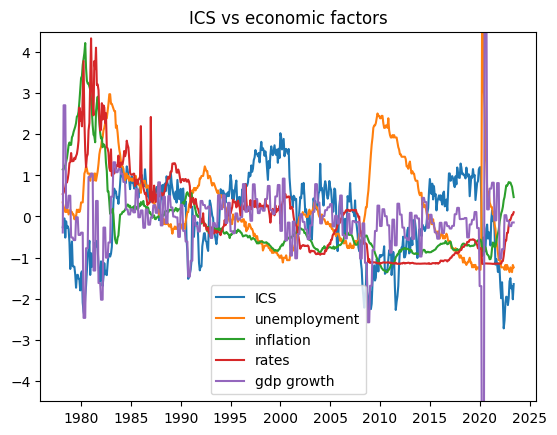

In [15]:
plt.plot(norm(data.ICS))
plt.plot(data.unemployment)
plt.plot(data.inflation)
plt.plot(data.rates)
plt.plot(data.gdp_growth)
plt.legend(['ICS', 'unemployment', 'inflation', 'rates', 'gdp growth'])
plt.ylim(-4.5, 4.5)
plt.title("ICS vs economic factors")
plt.show()

We can gather some information from the graph. Sentiment seems to go down when interest rates or unemployment are up, as expected

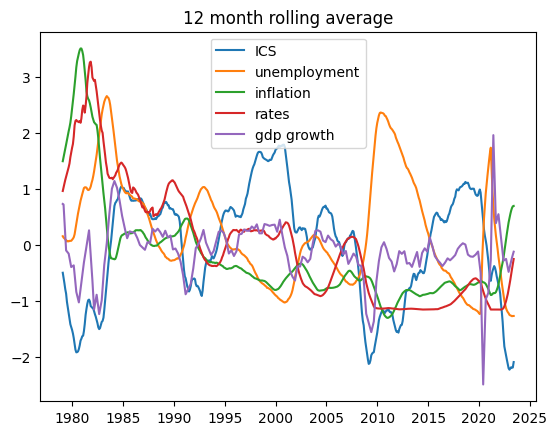

In [16]:
plt.plot(norm(data.ICS.rolling(12).mean()))
plt.plot(data.unemployment.rolling(12).mean())
plt.plot(data.inflation.rolling(12).mean())
plt.plot(data.rates.rolling(12).mean())
plt.plot(data.gdp_growth.rolling(12).mean())
plt.legend(['ICS', 'unemployment', 'inflation', 'rates', 'gdp growth'])
plt.title("12 month rolling average")
plt.show()

A 12 month rolling average may make this a little cleaner, particularly for metrics which fluctuate a lot.

In [17]:
data[['ICS', 'ICC', 'ICE', 'inflation', 'unemployment', 'rates', 'gdp_growth', 'dow_change']].corr()

,ICS,ICC,ICE,inflation,unemployment,rates,gdp_growth,dow_change
ICS,1.000000,0.946372,0.974818,-0.364725,-0.427974,-0.003426,0.261925,0.132438
ICC,0.946372,1.000000,0.850492,-0.294221,-0.484114,0.022789,0.237683,0.102334
ICE,0.974818,0.850492,1.000000,-0.390702,-0.362609,-0.021305,0.262366,0.144979
inflation,-0.364725,-0.294221,-0.390702,1.000000,0.109287,0.800071,-0.083199,-0.035617
unemployment,-0.427974,-0.484114,-0.362609,0.109287,1.000000,0.125329,-0.139030,0.046479
rates,-0.003426,0.022789,-0.021305,0.800071,0.125329,1.000000,0.037201,-0.016568
gdp_growth,0.261925,0.237683,0.262366,-0.083199,-0.139030,0.037201,1.000000,0.107125
dow_change,0.132438,0.102334,0.144979,-0.035617,0.046479,-0.016568,0.107125,1.000000


We can see there is some correlation between the sentiment scores and inflation, unemployment, gdp growth, and the dow change. None of them are particularly correlated with each other. However interest rates appear to be very correlated with inflation. This makes sense as interest rates are often raised to combat inflation. This means it may not be a particularly good candidate for regression.

We can also look at some summary statstics on each variable.

In [18]:
data[['ICS', 'ICC', 'ICE', 'inflation', 'unemployment', 'rates', 'gdp_growth', 'dow_change']].describe()

,ICS,ICC,ICE,inflation,unemployment,rates,gdp_growth,dow_change
count,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,5.440000e+02
mean,86.008919,97.915338,78.358387,-0.161905,0.240122,0.020409,-0.097041,-6.530724e-18
std,13.479064,14.610844,13.597382,0.967399,1.031013,1.071449,0.989430,1.000000e+00
min,49.282608,53.548571,44.683748,-1.354413,-1.356184,-1.158070,-8.082416,-5.701931e+00
25%,75.297195,87.428726,68.318522,-0.745097,-0.492420,-0.910315,-0.360131,-5.699568e-01
50%,89.604607,101.977263,80.800564,-0.498471,0.049263,-0.043172,-0.063481,6.510455e-02
75%,95.869145,108.545088,88.543600,0.130394,0.869107,0.574338,0.219584,5.649803e-01
max,113.337352,121.664360,109.857609,4.223312,5.261130,4.337589,6.194589,2.942073e+00


And how they the sample after 2020 is different.

In [19]:
data[['ICS', 'ICC', 'ICE', 'inflation', 'unemployment', 'rates', 'gdp_growth', 'dow_change']][data.index < '2020'].describe()

,ICS,ICC,ICE,inflation,unemployment,rates,gdp_growth,dow_change
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,87.204212,99.567816,79.259955,-0.158189,0.276155,0.093791,-0.084401,0.003959
std,12.869788,13.309601,13.410478,0.988425,0.965422,1.076653,0.635856,0.960467
min,53.254111,56.495760,44.683748,-1.354413,-1.297624,-1.158070,-2.576338,-5.701931
25%,77.548221,91.277246,69.595262,-0.739475,-0.419219,-0.847125,-0.358792,-0.538574
50%,91.063276,103.521005,81.817535,-0.498471,0.049263,0.085710,-0.059383,0.067803
75%,96.318600,109.107285,88.625969,0.113260,0.869107,0.742011,0.217195,0.558456
max,113.337352,121.664360,109.857609,4.223312,2.977278,4.337589,2.707906,2.942073


In [20]:
data[['ICS', 'ICC', 'ICE', 'inflation', 'unemployment', 'rates', 'gdp_growth', 'dow_change']][data.index >= '2020'].describe()

,ICS,ICC,ICE,inflation,unemployment,rates,gdp_growth,dow_change
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,71.722321,78.164296,67.582499,-0.206325,-0.190555,-0.856689,-0.248115,-0.047316
std,12.478266,15.151940,11.053358,0.673796,1.575793,0.430609,2.828351,1.403197
min,49.282608,53.548571,46.541412,-1.041548,-1.356184,-1.155568,-8.082416,-4.146663
25%,62.473864,66.991057,59.552816,-0.764565,-1.239064,-1.148060,-0.795110,-0.932432
50%,70.564954,76.089172,66.693032,-0.523199,-0.946262,-1.145558,-0.103333,0.058242
75%,80.431345,87.597039,74.091651,0.472032,0.268864,-0.631278,0.679377,0.843174
max,102.200339,116.691337,93.162500,0.837052,5.261130,0.103228,6.194589,2.908096


One thing to note is that unemployment is very volatile in 2020, reaching nearly 15%, far higher than it ever got before in the dataset. GDP growth has a similar level of volatility.

In [21]:
def try_model(data, form, predicted=data.ICS, y_min=50, y_max=150, neutral=100):
    fig,axis = plt.subplots()
    data_precovid = data[data.index < '2020-02-01']
    model_precovid = smf.ols(formula=form, data=data, subset=data.index < '2020-02-01').fit()
    model_full = smf.ols(formula=form, data=data).fit()
    axis.plot(predicted)
    for name, model in zip(["Pre-Covid", "Full"], [model_precovid, model_full]):
        print(f"Model {name}")
        print(model.summary())
        plt.plot(model.predict(data))
    axis.axhline(y = predicted.mean(), color='lightgrey')
    axis.legend(['sentiment', 'pre-covid', 'full', 'mean'])
    title = form if len(form) < 100 else form[:97]+"..."
    plt.title(title)
    axis.set_ylim(y_min, y_max)
    plt.show()
    return model_precovid, model_full

First let's try a model with just inflation and unemployment.

Model Pre-Covid
                            OLS Regression Results                            
Dep. Variable:                    ICS   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     195.0
Date:                Tue, 22 Aug 2023   Prob (F-statistic):           2.55e-63
Time:                        10:33:12   Log-Likelihood:                -1853.5
No. Observations:                 503   AIC:                             3713.
Df Residuals:                     500   BIC:                             3726.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       88.7055      0.4

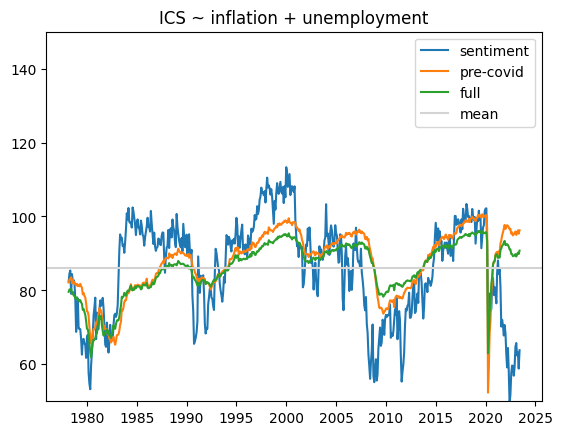

In [22]:
_, model = try_model(form="ICS ~ inflation + unemployment", data=data)

Already we have an adjusted R^2 of 0.436. Almost half of the effect can be explained with these two variables.

Now lets in add in gdp growth and dow change.

Model Pre-Covid
                            OLS Regression Results                            
Dep. Variable:                    ICS   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     172.5
Date:                Tue, 22 Aug 2023   Prob (F-statistic):           1.40e-92
Time:                        10:33:13   Log-Likelihood:                -1779.8
No. Observations:                 503   AIC:                             3570.
Df Residuals:                     498   BIC:                             3591.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       89.3870      0.4

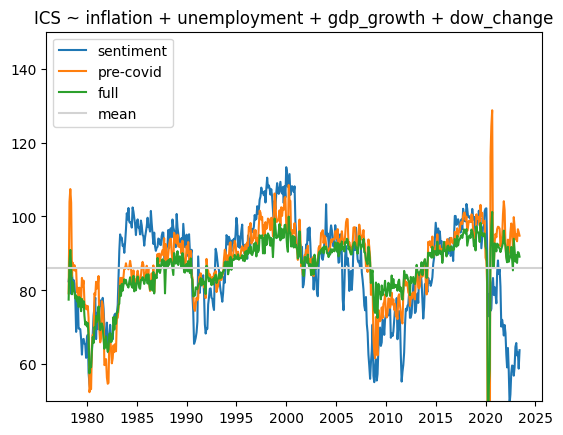

In [23]:
_, model = try_model(form="ICS ~ inflation + unemployment + gdp_growth + dow_change",
                     data=data)

It does pretty well until 2020. At 2020 it goes haywire while the unemployment rate temporarily spikes. Afterwards it overestimates sentiment.

On the theory that past data is more important, we can also try 12 month rolling averages of the input variables. Inflation we can keep as a current value since it is already year over year.

Model Pre-Covid
                            OLS Regression Results                            
Dep. Variable:                    ICS   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     243.7
Date:                Tue, 22 Aug 2023   Prob (F-statistic):          9.35e-115
Time:                        11:35:20   Log-Likelihood:                -1687.5
No. Observations:                 492   AIC:                             3385.
Df Residuals:                     487   BIC:                             3406.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept       

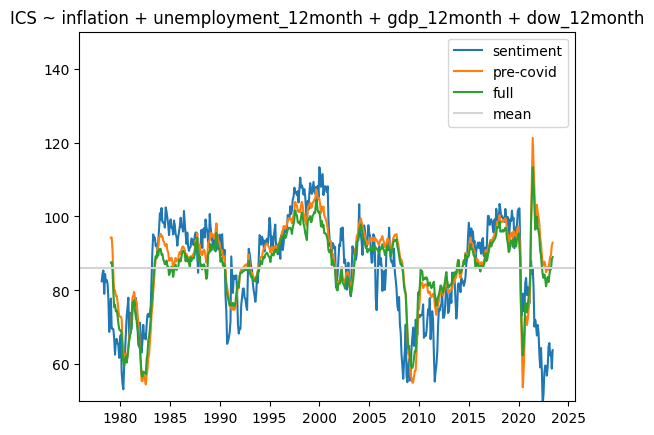

In [120]:
data['unemployment_12month'] = data.unemployment.rolling(12).mean()
data['gdp_12month'] = data.gdp_growth.rolling(12).mean()
data['dow_12month'] = data.dow_change.rolling(12).mean()
_, model = try_model(form="ICS ~ inflation + unemployment_12month + " +
                     "gdp_12month + dow_12month",
                     data=data)

This does better. The adjusted R^2 is 0.664 pre covid and 0.488 for the entire time.

Let's add in an interaction between inflation and unemployment. What happens when both of these are high, or both are low?

Model Pre-Covid
                            OLS Regression Results                            
Dep. Variable:                    ICS   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     262.7
Date:                Tue, 22 Aug 2023   Prob (F-statistic):          1.26e-135
Time:                        11:35:52   Log-Likelihood:                -1635.9
No. Observations:                 492   AIC:                             3284.
Df Residuals:                     486   BIC:                             3309.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

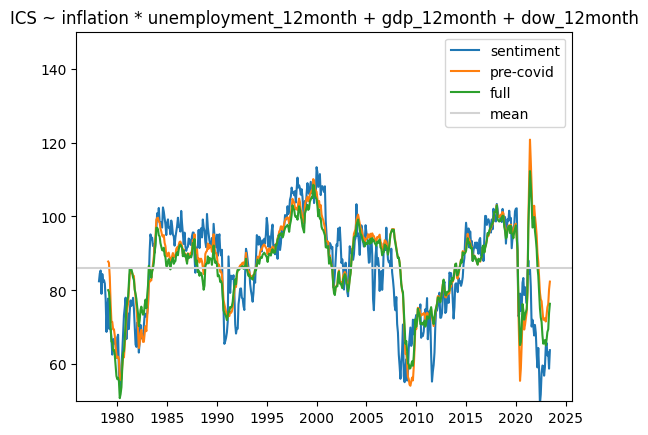

In [121]:
_, ics_model = try_model(form="ICS ~ inflation * unemployment_12month + " +
                         "gdp_12month + dow_12month",
                         data=data)

This does much better. Now we have a Adjusted R^2s of 0.727 and 0.624. We can also see it gives a positive value for the interaction term. This will serve to lessen the impact when both inflation and unemployment are both either high or low.

Let's look at the two partial sentitment values, ICE and ICC.

Model Pre-Covid
                            OLS Regression Results                            
Dep. Variable:                    ICC   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     337.5
Date:                Tue, 22 Aug 2023   Prob (F-statistic):          1.63e-155
Time:                        11:36:11   Log-Likelihood:                -1607.9
No. Observations:                 492   AIC:                             3228.
Df Residuals:                     486   BIC:                             3253.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

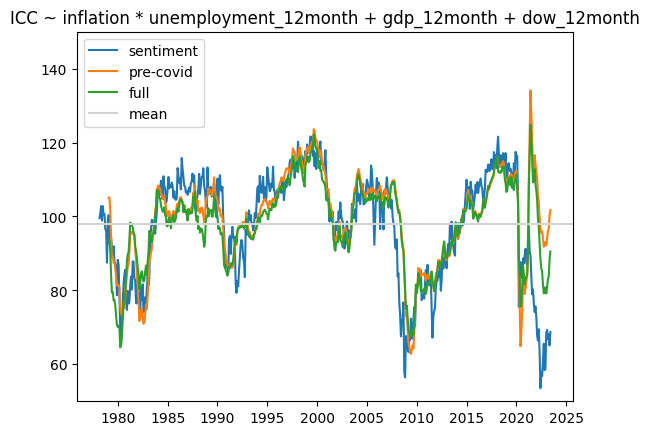

In [122]:
_, icc_model = try_model(form="ICC ~ inflation * unemployment_12month + " +
                         "gdp_12month + dow_12month",
                         data=data, predicted=data.ICC)

The current conditions is better predicted before 2020, but I see more of a discrepency with post pandemic results. In particular the pre 2020 model predicts sentiment should be neutral around now, and the one with all the data still thinks things should be better. This particular index is based on how families are actually doing and less to do with perceptions of the economy.

Model Pre-Covid
                            OLS Regression Results                            
Dep. Variable:                    ICE   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     175.0
Date:                Tue, 22 Aug 2023   Prob (F-statistic):          3.16e-106
Time:                        11:36:35   Log-Likelihood:                -1722.6
No. Observations:                 492   AIC:                             3457.
Df Residuals:                     486   BIC:                             3482.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

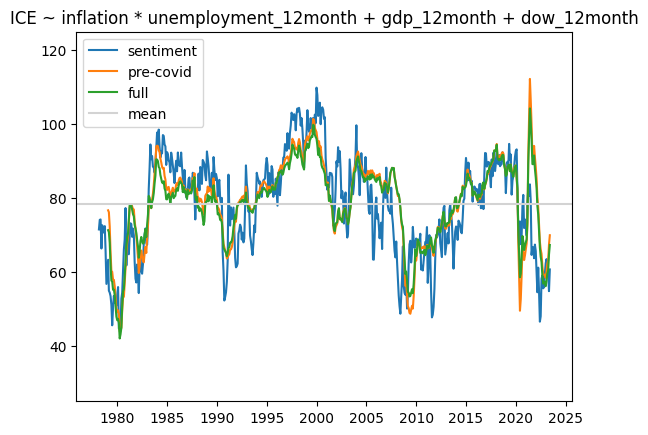

In [123]:
_, ice_model = try_model(form="ICE ~ inflation * unemployment_12month + " +
                         "gdp_12month + dow_12month",
                         data=data, predicted=data.ICE, y_min=25, y_max=125)

This does worse overall, but it is much closer today. It is harder to predict people's perceptions of the economy, but they seem pretty consistent before and after the pandemic.

We can also look at how consumer sentiment would change with different unemployment and inflation rates assuming the most recent Dow and GDP data.

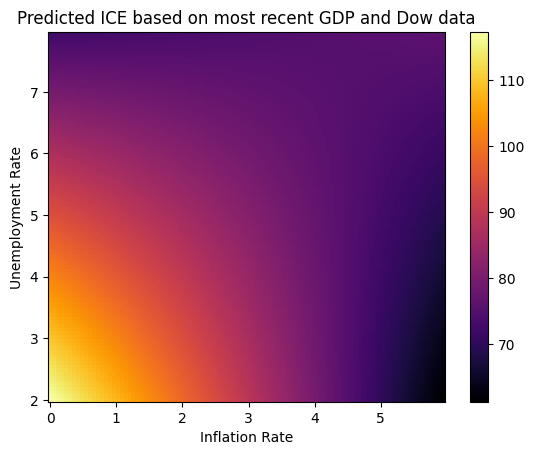

In [199]:
inflation_axis, unemployment_axis = np.meshgrid(np.arange(0, 6, 6/100), np.arange(2, 8, 6/100))

mesh_df = pd.DataFrame({'inflation': norm(inflation_axis.reshape((-1)), with_data=inflation.CORESTICKM159SFRBATL), 
                        'unemployment_12month': norm(unemployment_axis.reshape((-1)), with_data=unemployment.UNRATE),
                        'gdp_12month': data.gdp_12month[-1], 
                        'dow_12month': data.dow_12month[-1]})

sentiment_axis = np.array(ice_model.predict(mesh_df)).reshape((100,100))

plt.pcolormesh(inflation_axis, unemployment_axis, sentiment_axis, cmap="inferno")
plt.xlabel('Inflation Rate')
plt.ylabel('Unemployment Rate')
plt.colorbar()
plt.title("Predicted ICE based on most recent GDP and Dow data")
plt.show()

Sentiment is high when both inflation and unemployment are low, low when one is high.

Don't be fooled by the top right corner getting lighter, we don't have much data with both a high inflation rate and high unemployment rate, so the model does not extrapolate to that region very well.